# Plot input variables

This script will help us make some nice plots that show the input variables for training

## Setup and Config

Modify the below things to change what things are plotted

In [1]:
local_files = "G:\\GRIDDocker\\mc16_13TeV.311309.MadGraphPythia8EvtGen_A14NNPDF31LO_HSS_LLP_mH125_mS5_ltlow.deriv.DAOD_EXOT15.e7270_e5984_s3234_r10724_r10726_p3795\\*.root.*"

In [2]:
# Designed not to be modified
import sys
sys.path.append("../")
from adl_func_client.event_dataset import EventDataset
from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', size=14)

## Load Datasets

In [3]:
def get_all_files(wildcard):
    return [f"file://{f}" for f in glob.glob(wildcard)]

In [4]:
%time
df = EventDataset(get_all_files(local_files))
m125_m55_ltlow = fetch_perjet_data(df, "m125_m55_ltlow")

Wall time: 0 ns
Result of run: 0


In [5]:
%time
m125_m55_ltlow

Wall time: 0 ns


,RunNumber,EventNumber,JetPt,JetEta,IsLLP,nLLPs_Near_Jets,Lx,Ly,Lz,EMM_BL0,...,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2,FC_L0,FC_L1,FC_L2
entry,,,,,,,,,,,,,,,,,,,,,
0,310000.0,90327.0,64.974809,-1.428163,True,1,418.350891,773.259521,1630.686279,0.169868,...,0.000000,0.002809,-0.000201,0.009597,0.094244,0.062647,0.000864,0.0,0.0,0.0
1,310000.0,91145.0,56.910492,0.756049,True,1,857.133057,381.493530,751.490112,0.078879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,310000.0,90172.0,64.407121,2.412120,True,1,311.374298,488.122955,3199.765869,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,310000.0,90172.0,52.183625,-0.777530,False,0,0.000000,0.000000,0.000000,0.049095,...,0.004186,0.002802,0.001572,-0.017096,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,310000.0,90488.0,41.087871,1.110804,False,0,0.000000,0.000000,0.000000,0.206766,...,0.000000,0.012284,0.002592,0.010629,0.002376,0.012412,0.034142,0.0,0.0,0.0
5,310000.0,91370.0,358.033437,1.251362,False,0,0.000000,0.000000,0.000000,0.042932,...,0.000000,0.000529,0.000000,0.069947,0.139373,0.078548,0.005364,0.0,0.0,0.0
6,310000.0,90493.0,57.123637,-0.753590,True,1,1435.569824,754.213867,1311.229126,0.020076,...,0.000529,0.001282,-0.000285,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,310000.0,90576.0,64.933199,-0.593100,True,1,1436.871460,308.469269,870.330811,0.027960,...,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,310000.0,90478.0,112.377102,-1.706667,False,0,0.000000,0.000000,0.000000,0.002145,...,0.000000,0.000000,0.000000,0.026636,0.022038,0.002674,-0.001756,0.0,0.0,0.0


## Standard Kinematic Plots

Regular plots of jet pt, etc.

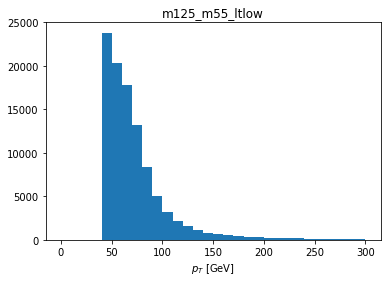

In [6]:
plt.hist(m125_m55_ltlow.JetPt, bins=30, range=(0,300))
plt.title('m125_m55_ltlow')
_ = plt.xlabel('$p_T$ [GeV]')

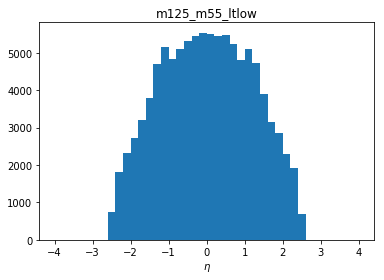

In [7]:
plt.hist(m125_m55_ltlow.JetEta, bins=8*5, range=(-4.0,4.0))
plt.title('m125_m55_ltlow')
_ = plt.xlabel('$\eta$')

## Long Lived Particle Truth

Look at the various truth variables that have come out

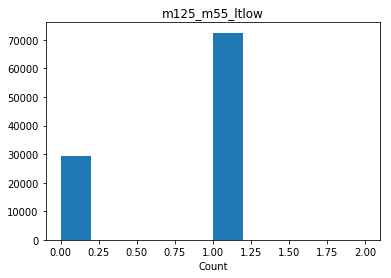

In [9]:
plt.hist(m125_m55_ltlow.nLLPs_Near_Jets)
plt.title('m125_m55_ltlow')
_ = plt.xlabel('Count')

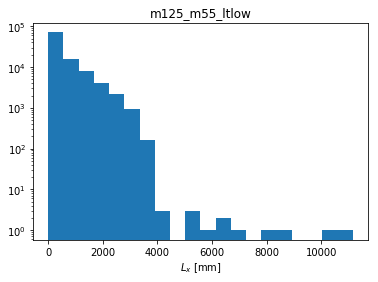

In [19]:
plt.hist(m125_m55_ltlow.Lx, bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('$L_x$ [mm]')

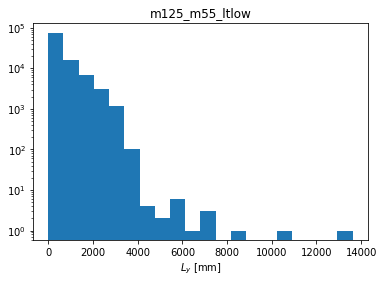

In [20]:
plt.hist(m125_m55_ltlow.Ly, bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('$L_y$ [mm]')

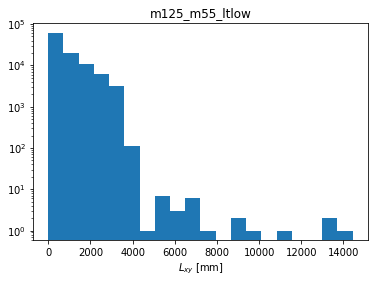

In [21]:
plt.hist(np.sqrt(m125_m55_ltlow.Lx*m125_m55_ltlow.Lx + m125_m55_ltlow.Ly*m125_m55_ltlow.Ly), bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('$L_{xy}$ [mm]')

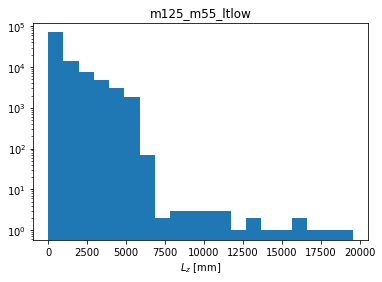

In [22]:
plt.hist(m125_m55_ltlow.Lz, bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('$L_z$ [mm]')

## MLP Input Variables

Look at the input variables for Lxy predictor

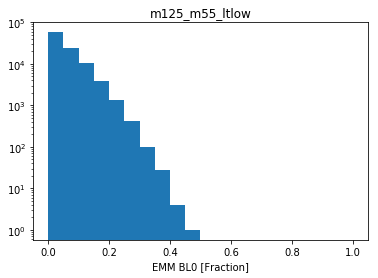

In [26]:
plt.hist(m125_m55_ltlow.EMM_BL0, range=(0.0,1.0), bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('EMM BL0 [Fraction]')